In [1]:
from crypto_volatility_lab.data_construction.cryptoScraper import CryptoScraper
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
crypto_scraper = CryptoScraper(start_date="2014-09-17")
bitcoin_data = crypto_scraper.get_data_for_currency('BTC-USD')

In [3]:
print(bitcoin_data.shape)
bitcoin_data.tail()

(3748, 7)


,Date,Open,High,Low,Close,Adj,Volume
3743,"Sep 21, 2014",408.08,412.43,393.18,398.82,398.82,"26,580,100"
3744,"Sep 20, 2014",394.67,423.30,389.88,408.90,408.90,"36,863,600"
3745,"Sep 19, 2014",424.10,427.83,384.53,394.80,394.80,"37,919,700"
3746,"Sep 18, 2014",456.86,456.86,413.10,424.44,424.44,"34,483,200"
3747,"Sep 17, 2014",465.86,468.17,452.42,457.33,457.33,"21,056,800"


In [4]:
bitcoin_data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj', 'Volume'], dtype='object')

C:\Users\emmae\AppData\Local\Temp\ipykernel_88404\2920437746.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.xticks(pd.date_range(start=bitcoin_data['Date'].min(), end=bitcoin_data['Date'].max(), freq='6M'), rotation=45)


Text(0.5, 1.0, 'Bitcoin Price')

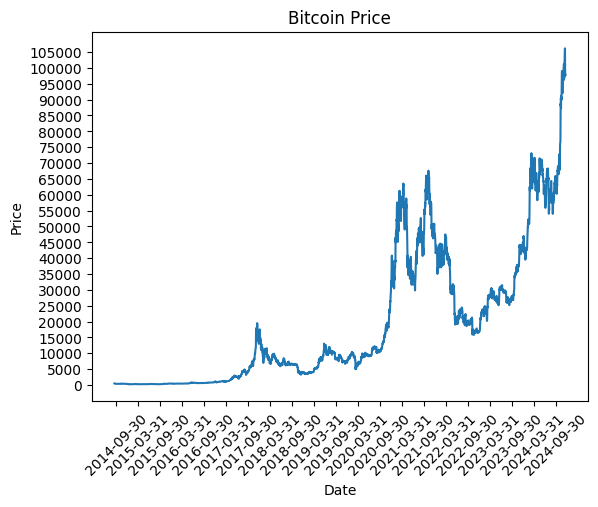

In [5]:
bitcoin_data['Date'] = pd.to_datetime(bitcoin_data['Date'])
bitcoin_data['Close'] = pd.to_numeric(bitcoin_data['Close'].str.replace(',', ''))

plt.plot(bitcoin_data['Date'], bitcoin_data['Close'])
plt.xlabel('Date')
plt.xticks(pd.date_range(start=bitcoin_data['Date'].min(), end=bitcoin_data['Date'].max(), freq='6M'), rotation=45)
plt.yticks(ticks=range(0, int(bitcoin_data['Close'].max()), 5000))
plt.ylabel('Price')
plt.title('Bitcoin Price')